# 정형화(Regularizaion)와 축소(Shrinkage)

- 고차원 데이터를 다루게 되면서 과대 적합 방지가 매우 중요해짐
- 정형화와 축소 방법을 사용해서 과대 적합을 해결할 수 있음

## 1. 일래스틱 넷(Elastic Net)

- 라쏘(Lasso)회귀와 능형(Ridge)회귀의 혼합 방법
- 라쏘 회귀 : 변수 선택과 차원 축소를 위해 L1 페널티 사용(절대값)
- 능형 회귀 : 더 안정된 예측을 위해서 L2 페널티 사용(제곱항)

In [2]:
acs <- read.table("http://jaredlander.com/data/acs_ny.csv", sep = "," , header=TRUE, stringsAsFactors=FALSE)

In [3]:
testFrame <- data.frame(First=sample(1:10, 20, replace=T),
                        Second=sample(1:20, 20, replace=T),
                        Third=sample(1:10, 20, replace=T),
                        Fourth=factor(rep(c("Alice", "Bob", "Charlie", "David"), 5)),
                        Fifth=ordered(rep(c("Edward", "Frank", "Georgia", "Hank", "Isaac"), 4)),
                        Sixth=rep(c("a","b"),10), stringsAsFactors=F)

In [4]:
head(testFrame)

First,Second,Third,Fourth,Fifth,Sixth
8,9,7,Alice,Edward,a
6,9,9,Bob,Frank,b
7,19,3,Charlie,Georgia,a
1,11,2,David,Hank,b
7,2,7,Alice,Isaac,a
2,15,7,Bob,Edward,b


In [5]:
head(model.matrix(First ~ Second + Fourth + Fifth, testFrame))

,(Intercept),Second,FourthBob,FourthCharlie,FourthDavid,Fifth.L,Fifth.Q,Fifth.C,Fifth^4
1,1,9,0,0,0,-6.324555e-01,0.5345225,-3.162278e-01,0.1195229
2,1,9,1,0,0,-3.162278e-01,-0.2672612,6.324555e-01,-0.4780914
3,1,19,0,1,0,-1.481950e-18,-0.5345225,1.786843e-17,0.7171372
4,1,11,0,0,1,3.162278e-01,-0.2672612,-6.324555e-01,-0.4780914
5,1,2,0,0,0,6.324555e-01,0.5345225,3.162278e-01,0.1195229
6,1,15,1,0,0,-6.324555e-01,0.5345225,-3.162278e-01,0.1195229


- 팩터의 베이스 레벨에 대한 지표 변수를 만들지 않는 것은 대부분의 선형 모형에서 다중공선성을 피하기 위함이다.
- 그러나 일래스틱 넷을 사용하려는 경우 예측 변수 행렬을 이렇게 처리하면 안된다.
- 팩터의 모든 레벨을 반환하도록 하는 것이 가능하고 useful 패키지의 build.x 함수를 사용한다.

In [6]:
library("useful")

Loading required package: ggplot2


In [7]:
head(build.x(First ~ Second + Fourth + Fifth , testFrame, contrast = FALSE))

,(Intercept),Second,FourthAlice,FourthBob,FourthCharlie,FourthDavid,FifthEdward,FifthFrank,FifthGeorgia,FifthHank,FifthIsaac
1,1,9,1,0,0,0,1,0,0,0,0
2,1,9,0,1,0,0,0,1,0,0,0
3,1,19,0,0,1,0,0,0,1,0,0
4,1,11,0,0,0,1,0,0,0,1,0
5,1,2,1,0,0,0,0,0,0,0,1
6,1,15,0,1,0,0,1,0,0,0,0


In [9]:
head(build.x(First ~ Second + Fourth + Fifth , testFrame, contrast = c(Fourth=FALSE, Fifth=TRUE)))

,(Intercept),Second,FourthAlice,FourthBob,FourthCharlie,FourthDavid,Fifth.L,Fifth.Q,Fifth.C,Fifth^4
1,1,9,1,0,0,0,-6.324555e-01,0.5345225,-3.162278e-01,0.1195229
2,1,9,0,1,0,0,-3.162278e-01,-0.2672612,6.324555e-01,-0.4780914
3,1,19,0,0,1,0,-1.481950e-18,-0.5345225,1.786843e-17,0.7171372
4,1,11,0,0,0,1,3.162278e-01,-0.2672612,-6.324555e-01,-0.4780914
5,1,2,1,0,0,0,6.324555e-01,0.5345225,3.162278e-01,0.1195229
6,1,15,0,1,0,0,-6.324555e-01,0.5345225,-3.162278e-01,0.1195229


- acs 데이터를 활용해서 모형 설정

In [10]:
acs$Income <- with(acs, FamilyIncome >= 150000) # 이진 변수 생성
head(acs)

Acres,FamilyIncome,FamilyType,NumBedrooms,NumChildren,NumPeople,NumRooms,NumUnits,NumVehicles,NumWorkers,OwnRent,YearBuilt,HouseCosts,ElectricBill,FoodStamp,HeatingFuel,Insurance,Language,Income
1-10,150,Married,4,1,3,9,Single detached,1,0,Mortgage,1950-1959,1800,90,No,Gas,2500,English,FALSE
1-10,180,Female Head,3,2,4,6,Single detached,2,0,Rented,Before 1939,850,90,No,Oil,0,English,FALSE
1-10,280,Female Head,4,0,2,8,Single detached,3,1,Mortgage,2000-2004,2600,260,No,Oil,6600,Other European,FALSE
1-10,330,Female Head,2,1,2,4,Single detached,1,0,Rented,1950-1959,1800,140,No,Oil,0,English,FALSE
1-10,330,Male Head,3,1,2,5,Single attached,1,0,Mortgage,Before 1939,860,150,No,Gas,660,Spanish,FALSE
1-10,480,Male Head,0,3,4,1,Single detached,0,0,Rented,Before 1939,700,140,No,Gas,0,English,FALSE


- 예측 행렬 만들기

In [11]:
acsX <- build.x(Income ~ NumBedrooms + NumChildren + NumPeople +
               NumRooms + NumUnits + NumVehicles + NumWorkers +
               OwnRent + YearBuilt + ElectricBill + FoodStamp +
               HeatingFuel + Insurance + Language - 1,
               data = acs , contrasts=FALSE) # glmnet 함수가 자동으로 절편으로 추가하기 때문에 절편을 넣지 않는다.

In [12]:
class(acsX)

[1] "matrix"

In [13]:
dim(acsX)

[1] 22745    44

In [14]:
topleft(acsX, c=6)

,NumBedrooms,NumChildren,NumPeople,NumRooms,NumUnitsMobile home,NumUnitsSingle attached
1,4,1,3,9,0,0
2,3,2,4,6,0,0
3,4,0,2,8,0,0
4,2,1,2,4,0,0
5,3,1,2,5,0,1


In [16]:
topright(acsX, c=6)

,Insurance,LanguageAsian Pacific,LanguageEnglish,LanguageOther,LanguageOther European,LanguageSpanish
1,2500,0,1,0,0,0
2,0,0,1,0,0,0
3,6600,0,0,0,1,0
4,0,0,1,0,0,0
5,660,0,0,0,0,1


- 응답 행렬 만들기

In [17]:
acsY <- build.y(Income ~ NumBedrooms + NumChildren + NumPeople +
               NumRooms + NumUnits + NumVehicles + NumWorkers +
               OwnRent + YearBuilt + ElectricBill + FoodStamp +
               HeatingFuel + Insurance + Language - 1,
               data = acs)

In [18]:
head(acsY)

[1] FALSE FALSE FALSE FALSE FALSE FALSE

In [19]:
tail(acsY)

[1] TRUE TRUE TRUE TRUE TRUE TRUE

- glmnet 패키지의 cv.glmnet 함수를 사용해서 교차 타당성을 계산
- 여기서 가장 중요한 정보
    - 교차 타당성에 대한 것
    - 교차 타당성 오차를 최소화 하는 람다 값
- 약간 덜 정확하더라도 더 단순한 모형을 선택하는 것이 좋다    


In [20]:
library(glmnet)

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-13



In [21]:
set.seed(1863561)

In [22]:
acsCV1 <- cv.glmnet(x=acsX, y=acsY, family = "binomial", nfold=5)

In [23]:
acsCV1$lambda.min

[1] 0.0005258299

In [24]:
acsCV1$lambda.1se

[1] 0.006482677

- 왼쪽에 있는 수직 점선은 오차가 최소가 되는 지점의 람다 값
- 오른쪽 수직 점선은 최솟값의 1 표준편차 이내에 있는 두 번째로 큰 람다 값

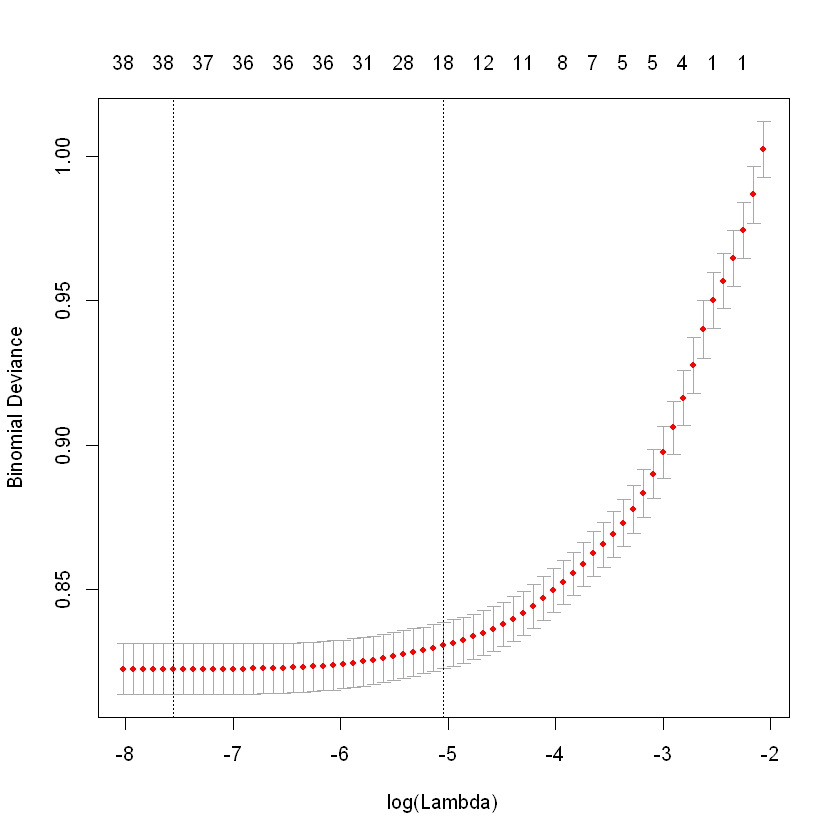

In [25]:
plot(acsCV1)

- 계수를 추출하는 것은 coef 함수를 사용하지만 특정 람다 값을 지정해줘야 한다.

In [26]:
coef(acsCV1, s="lambda.1se")

45 x 1 sparse Matrix of class "dgCMatrix"
                                    1
(Intercept)             -5.0552170103
NumBedrooms              0.0542621380
NumChildren              .           
NumPeople                .           
NumRooms                 0.1102021934
NumUnitsMobile home     -0.8960712560
NumUnitsSingle attached  .           
NumUnitsSingle detached  .           
NumVehicles              0.1283171343
NumWorkers               0.4806697219
OwnRentMortgage          .           
OwnRentOutright          0.2574766773
OwnRentRented           -0.1790627645
YearBuilt15              .           
YearBuilt1940-1949      -0.0253908040
YearBuilt1950-1959       .           
YearBuilt1960-1969       .           
YearBuilt1970-1979      -0.0063336086
YearBuilt1980-1989       0.0147761442
YearBuilt1990-1999       .           
YearBuilt2000-2004       .           
YearBuilt2005            .           
YearBuilt2006            .           
YearBuilt2007            .           
YearBuil

- 라쏘 회귀에 대한 유의성 검정을 위해 lars 패키지를 사용한다
- 람다 경로를 따라서 모형에 들어가는 변수를 시각화 할 수 있다.

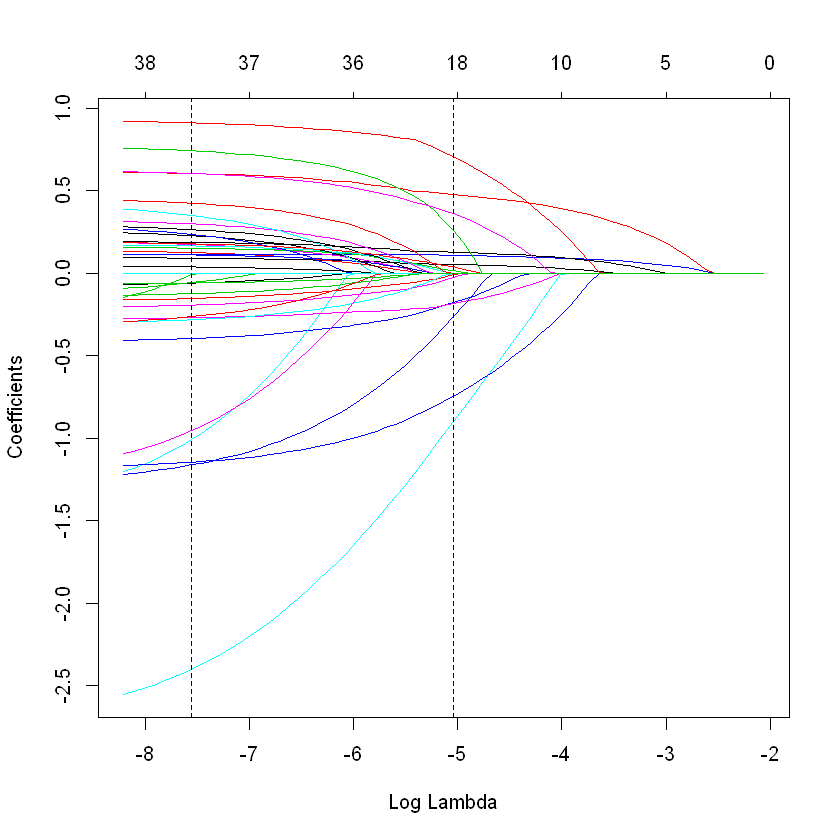

In [28]:
plot(acsCV1$glmnet.fit, xvar="lambda")
abline(v= log(c(acsCV1$lambda.min, acsCV1$lambda.1se)),lty=2)

- 알파 = 0으로 지정하면 능형(Ridge)회귀를 사용한 결과를 반환한다.
- 이 경우 변수들이 모형에 모두 유지되는 대신 0에 가깝게 축소된다.

In [29]:
set.seed(71623)
acsCV2 <- cv.glmnet(x=acsX, y=acsY, family="binomial",
                   nfold = 5, alpha = 0)

In [30]:
acsCV2$lambda.min
acsCV2$lambda.1se

[1] 0.01396651

[1] 0.04681018

In [31]:
coef(acsCV2, s="lambda.1se")

45 x 1 sparse Matrix of class "dgCMatrix"
                                    1
(Intercept)             -4.8197810188
NumBedrooms              0.1027963294
NumChildren              0.0308893447
NumPeople               -0.0203037177
NumRooms                 0.0918136969
NumUnitsMobile home     -0.8470874369
NumUnitsSingle attached  0.1714879712
NumUnitsSingle detached  0.0841095530
NumVehicles              0.1583881396
NumWorkers               0.3811651456
OwnRentMortgage          0.1985621193
OwnRentOutright          0.6480126218
OwnRentRented           -0.2548147427
YearBuilt15             -0.6828640400
YearBuilt1940-1949      -0.1082928305
YearBuilt1950-1959       0.0602009151
YearBuilt1960-1969       0.0081133932
YearBuilt1970-1979      -0.0816541923
YearBuilt1980-1989       0.1593567244
YearBuilt1990-1999       0.1218212609
YearBuilt2000-2004       0.1768690849
YearBuilt2005            0.2923210334
YearBuilt2006            0.2309044444
YearBuilt2007            0.3765019705
YearBuil

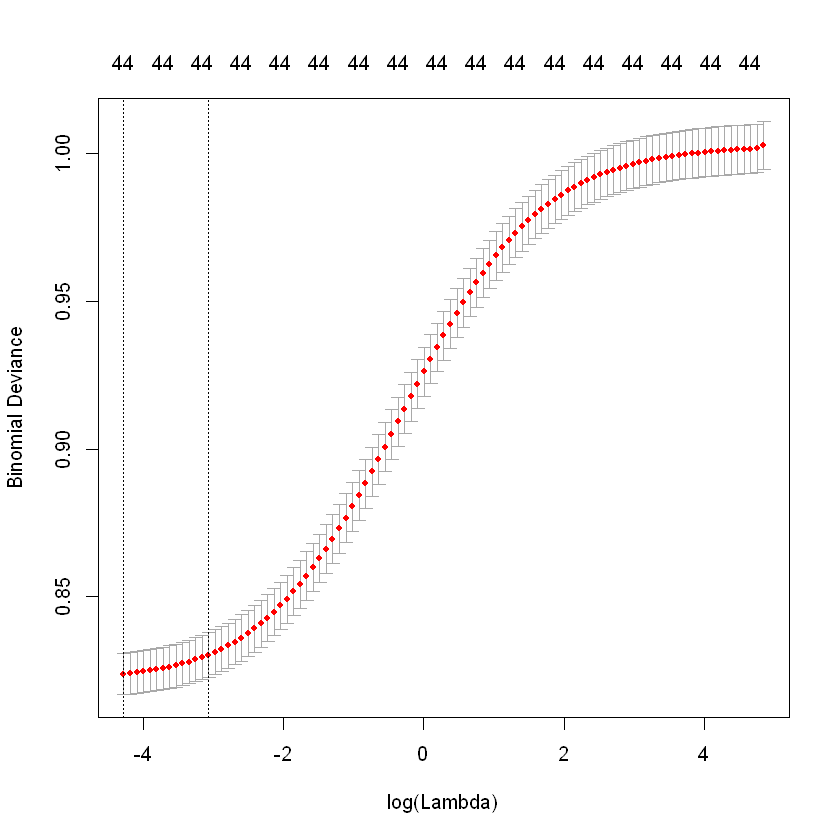

In [32]:
plot(acsCV2)

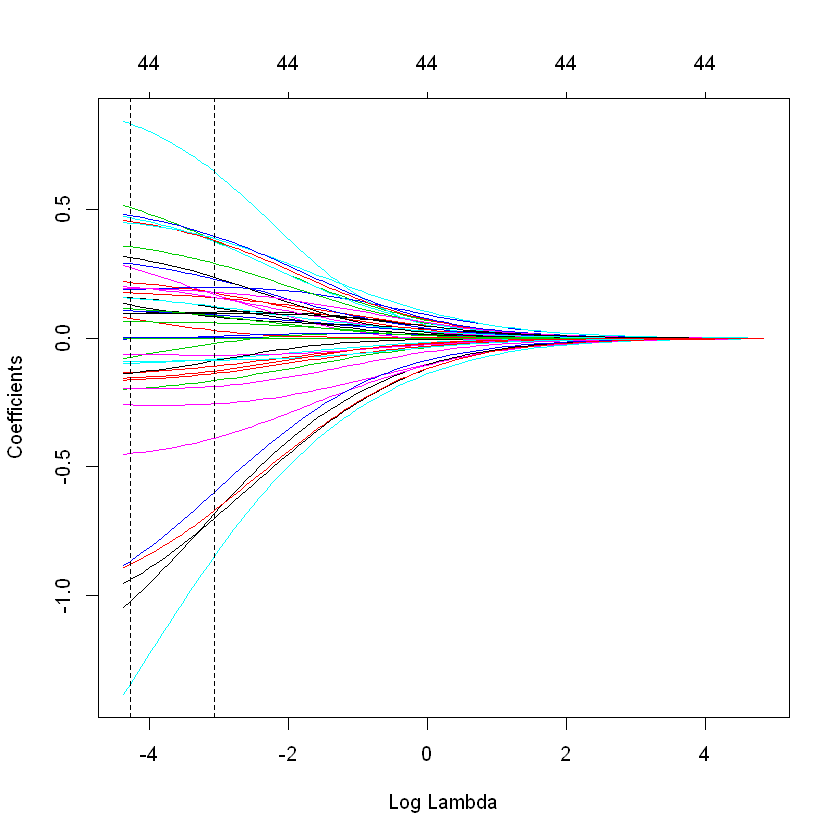

In [33]:
plot(acsCV2$glmnet, xvar="lambda")
abline(v=log(c(acsCV2$lambda.min, acsCV2$lambda.1se)),lty=2)

- 최적의 알파 값을 찾기 위해서는 여러 알파 값에 대해 cv.glmnet 함수를 반복 실행해야 한다.
- 코드를 병렬로 처리하는 방법 이용

In [34]:
library(parallel)

In [35]:
library(doParallel)

Loading required package: iterators


- 폴드 멤버십 정보를 담을 벡터 생성
- foreach가 순회할 일련의 알파 값을 지정
- 일반적으로 라쏘 방향으로 기울게 하는 것이 좋다고 알려져 있음(알파는 0.5보다 크게 지정)

In [36]:
set.seed(2834673)

In [37]:
# 폴드 만들기
# 실행될 때마다 관찰값들이 같은 폴드에 있도록 지정

theFolds <- sample(rep(x=1:5, length.out=nrow(acsX)))

In [38]:
# 알파 값 지정

alphas <- seq(from = 0.5, to = 1 , by =0.05)

- 병렬 처리 이전에 makeCluster와 registerDoParallel 함수로 하나의 클러스터를 시작하고 등록


- 처리를 마치면 stopCluster 함수를 사용해 클러스트를 멈춘다


- .errorhandling = "remove" 로 정하면 어떤 오류가 발생했을 때 순회를 건너뛰게 한다.


- .inorder = FALSE로 정하면 결과를 결합하는 순서가 중요하지 않아서 반환되는 대로 결합한다.


- 여러 개의 인자를 한꺼번에 취하므로 .multicombine = TRUE로 설정해 속도를 올릴 수 있다.


- .packages 인자에 glmnet 패키지를 지정해 각각의 워커마다 이 패키지를 로딩한다


- %dopar% 연산자는 foreach 함수에 병렬로 처리할 것이라는 것을 알려준다


- .export를 통해서 acsX, acsY, alphas, theFolds 같은 객체들을 명시적으로 로드하도록 한다.


In [39]:
set.seed(5127151)

In [40]:
cl <- makeCluster(2) # 2개의 워커를 가진 한 클러스터 시작

In [41]:
registerDoParallel(cl) # 워커 등록

In [42]:
before <- Sys.time() # 시간 트래킹

In [45]:
# foreach 루프 설정
# 인자들 지정

acsDouble <- foreach(i=1:length(alphas), .errorhandling="remove",
                    .inorder=FALSE, .multicombine=TRUE,
                    .export=c("acsX", "acsY", "alphas", "theFolds"),
                    .packages="glmnet") %dopar%
                    {
            print(alphas[i])
            cv.glmnet(x=acsX, y=acsY, family="binomial", nfolds=5,
                     foldid=theFolds, alpha=alphas[i])
                    }

Warning message in e$fun(obj, substitute(ex), parent.frame(), e$data):
"already exporting variable(s): acsX, acsY, alphas, theFolds"

In [46]:
# 타이머 종료
after <- Sys.time()

In [47]:
# 일을 마친 다음 클러스터 종료
stopCluster(cl)

In [48]:
# 시간 계산
after - before

Time difference of 3.54586 mins

In [49]:
# 리스트의 각 요소 클래스 체크
sapply(acsDouble, class)

[1] "cv.glmnet" "cv.glmnet" "cv.glmnet" "cv.glmnet" "cv.glmnet" "cv.glmnet"
 [7] "cv.glmnet" "cv.glmnet" "cv.glmnet" "cv.glmnet" "cv.glmnet"

In [50]:
# cv.glmnet 객체에 있는 정보를 추출하는 함수 정의
extractGlmnetInfo <- function(object){
    # 람다 찾기
    lambdaMin <- object$lambda.min
    lambda1se <- object$lambda.1se
    
    # 이들 람다가 어느 경로에 있는지 파악하기
    whichMin <- which(object$lambda == lambdaMin)
    which1se <- which(object$lambda == lambda1se)
    
    # 선택된 람다와 해당하는 오차값을 데이터 프레임의 한 행으로 만들기
    data.frame(lambda.min = lambdaMin, error.min = object$cvm[whichMin],
              lambda.1se = lambda1se, error.1se = object$cvm[which1se])
}

In [51]:
# 만든 함수를 리스트의 각 요소에 적용하기
# 그것들을 묶어서 하나의 데이터 프레임으로 만들기

alphaInfo <- Reduce(rbind, lapply(acsDouble, extractGlmnetInfo))

In [52]:
# plyr 패키지의 ldply 함수를 사용할 수도 있다.

alphaInfo2 <- plyr::ldply(acsDouble, extractGlmnetInfo)

In [53]:
identical(alphaInfo, alphaInfo2)

[1] TRUE

In [54]:
# alphas 값을 사용해 정리

alphaInfo$Alpha <- alphas

In [55]:
alphaInfo

lambda.min,error.min,lambda.1se,error.1se,Alpha
0.0009582333,0.8220268,0.008142621,0.8275240,0.50
0.0009560545,0.8220229,0.007402382,0.8273831,0.55
0.0008763832,0.8220198,0.006785517,0.8272666,0.60
0.0008089692,0.8220180,0.006263554,0.8271680,0.65
0.0008244253,0.8220170,0.005816158,0.8270837,0.70
0.0007694636,0.8220153,0.005428414,0.8270087,0.75
0.0007213721,0.8220140,0.005585323,0.8276055,0.80
0.0006789385,0.8220131,0.005256774,0.8275457,0.85
0.0006412197,0.8220125,0.004964731,0.8274930,0.90
0.0006074713,0.8220120,0.004703430,0.8274462,0.95


In [56]:
## 플롯팅에 사용된 정보를 담을 데이터 프레임 준비

library(reshape2)

In [57]:
library(stringr)

In [58]:
# 데이터를 롱폼으로 변환

alphaMelt <- melt(alphaInfo, id.vars="Alpha", value.name="Value",
                 variable.name = "Measure")

In [59]:
alphaMelt$Type <- str_extract(string=alphaMelt$Measure,
                             pattern="(min)|(1se)")

In [60]:
# 일부 정리 작업

alphaMelt$Measure <- str_replace(string=alphaMelt$Measure,
                                pattern="\\.(min|1se)",
                                replacement="")

In [61]:
alphaCast <- dcast(alphaMelt, Alpha + Type ~ Measure,
                  value.var="Value")

- 상단(1se) 기준으로 최적 알파는 0.75
- 하단(min) 기준으로 최적 알파는 0.95

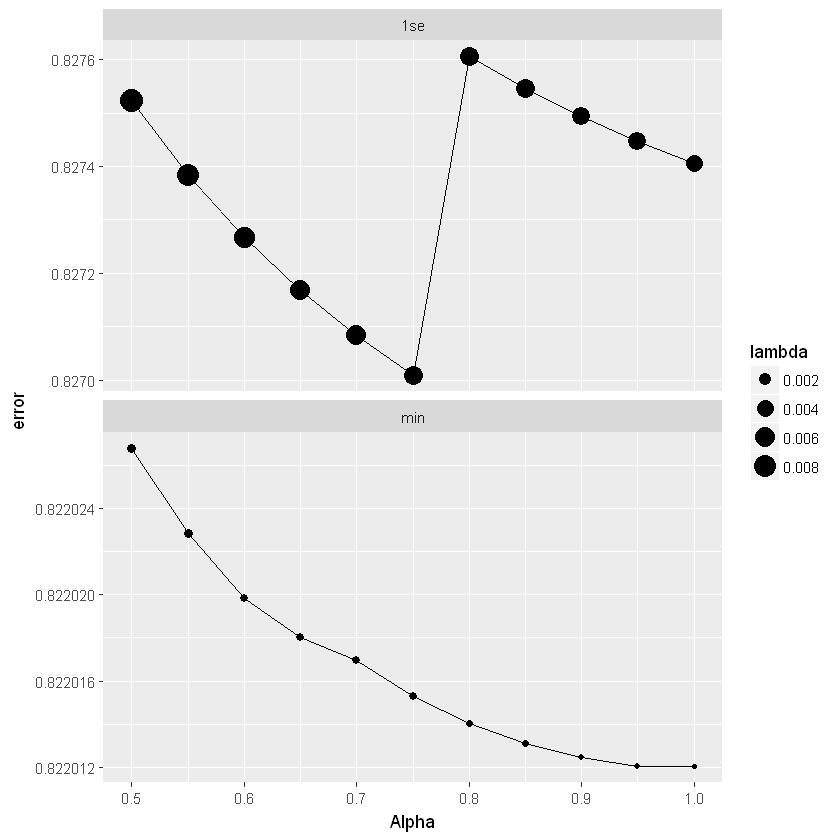

In [62]:
ggplot(alphaCast, aes(x=Alpha, y=error)) +
geom_line(aes(group=Type))+
facet_wrap(~Type, scales ="free_y", ncol=1)+
geom_point(aes(size=lambda))

- 알파 = 0.75 를 이용해서 다시 모형을 적합

In [63]:
set.seed(5127151)
acsCV3 <- cv.glmnet(x=acsX, y=acsY, family = "binomial", nfolds=5,
                   alpha = alphaInfo$Alpha[which.min(
                   alphaInfo$error.1se)])

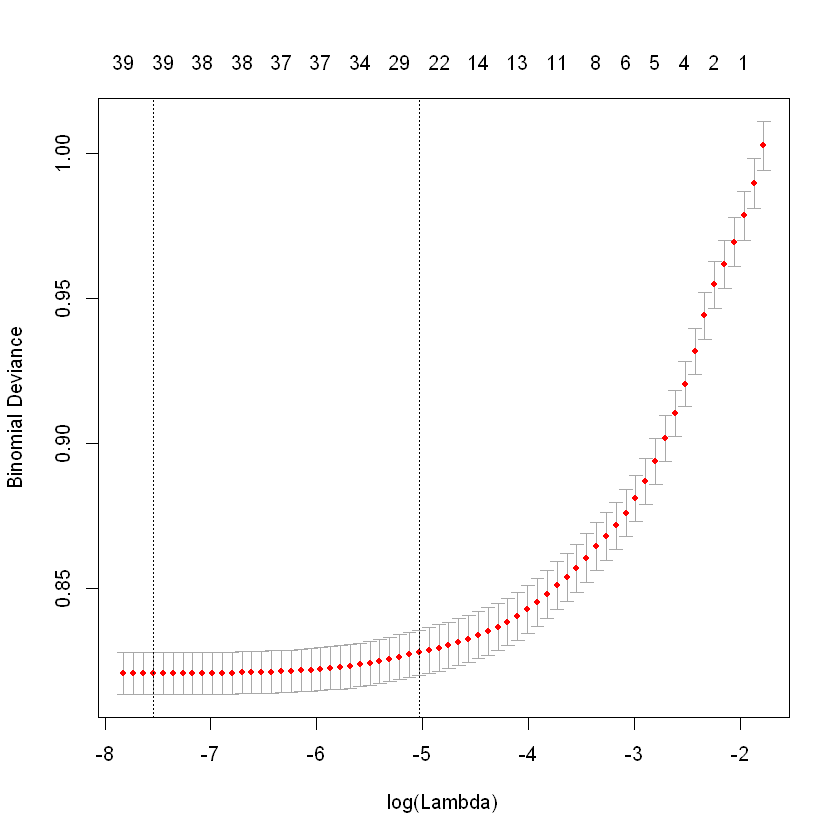

In [64]:
plot(acsCV3)

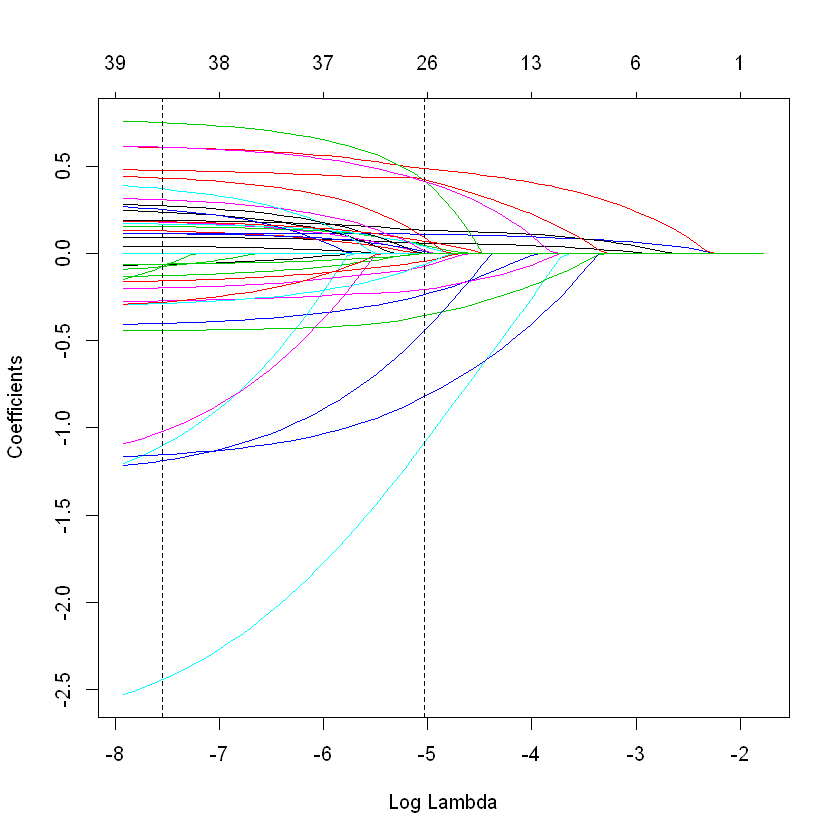

In [65]:
plot(acsCV3$glmnet.fit, xvar="lambda")
abline(v=log(c(acsCV3$lambda.min, acsCV3$lambda.1se)), lty=2)

In [66]:
theCoef <- as.matrix(coef(acsCV3, s="lambda.1se"))

In [67]:
coefDF <- data.frame(Value=theCoef, Coefficient=rownames(theCoef))

In [68]:
coefDF <- coefDF[nonzeroCoef(coef(acsCV3, s="lambda.1se")),]

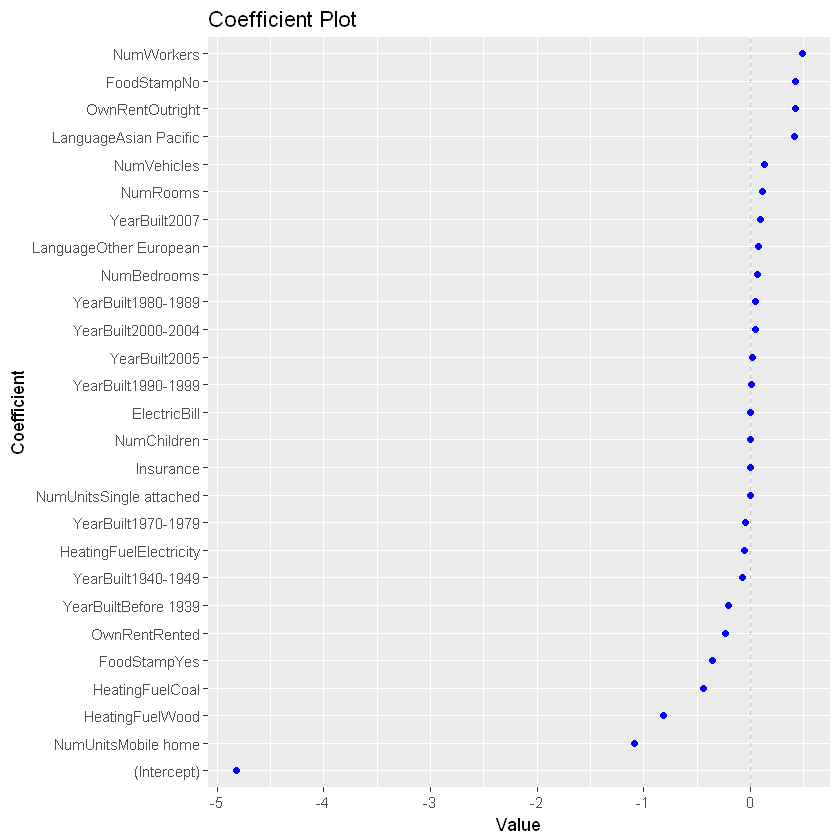

In [69]:
ggplot(coefDF, aes(x=X1, y=reorder(Coefficient,X1)))+
geom_vline(xintercept=0, color="grey", linetype=2)+
geom_point(color="blue")+
labs(x="Value", y="Coefficient", title="Coefficient Plot")

## 2. 베이즈 축소(Bayesian Shrinkage)

- 모형이 충분하지 않은 열의 수와 몇 개의 변수들로 구성된 데이터에 적용할 때 특히 유효

In [1]:
load("ideo.rdata")

In [2]:
head(ideo)

Year,Vote,Age,Gender,Race,Education,Income,Religion
1948,democrat,NA,male,white,grade school of less (0-8 grades),34 to 67 percentile,protestant
1948,republican,NA,female,white,"high school (12 grades or fewer, incl",96 to 100 percentile,protestant
1948,democrat,NA,female,white,"high school (12 grades or fewer, incl",68 to 95 percentile,catholic (roman catholic)
1948,republican,NA,female,white,"some college(13 grades or more,but no",96 to 100 percentile,protestant
1948,democrat,NA,male,white,"some college(13 grades or more,but no",68 to 95 percentile,catholic (roman catholic)
1948,republican,NA,female,white,"high school (12 grades or fewer, incl",96 to 100 percentile,protestant


In [3]:
library(dplyr)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



In [4]:
results <- ideo %>%
group_by(Year) %>%
# 세부 그룹에 모형을 적합
do(Model = glm(Vote ~ Race + Income + Gender + Education,
              data = .,
              family=binomial(link="logit")))

In [5]:
# 모형은 list-column으로 존재한다.
# 해당 열에 이름을 준다
names(results$Model) <- as.character(results$Year)

In [7]:
library(coefplot)

Loading required package: ggplot2


In [8]:
voteInfo <- multiplot(results$Model,
                     coefficients = "Raceblack", plot=FALSE)

In [9]:
head(voteInfo)

Value,Coefficient,HighInner,LowInner,HighOuter,LowOuter,Model
0.07119541,Raceblack,0.6297813,-0.4873905,1.1883673,-1.045976,1948
-1.68490828,Raceblack,-1.3175506,-2.0522659,-0.9501930,-2.419624,1952
-0.89178359,Raceblack,-0.5857195,-1.1978476,-0.2796555,-1.503912,1956
-1.07674848,Raceblack,-0.7099648,-1.4435322,-0.3431811,-1.810316,1960
-16.85751152,Raceblack,382.1171424,-415.8321655,781.0917963,-814.806819,1964
-3.65505395,Raceblack,-3.0580572,-4.2520507,-2.4610605,-4.849047,1968


Warning message:
"Ignoring unknown aesthetics: xmin, xmax"

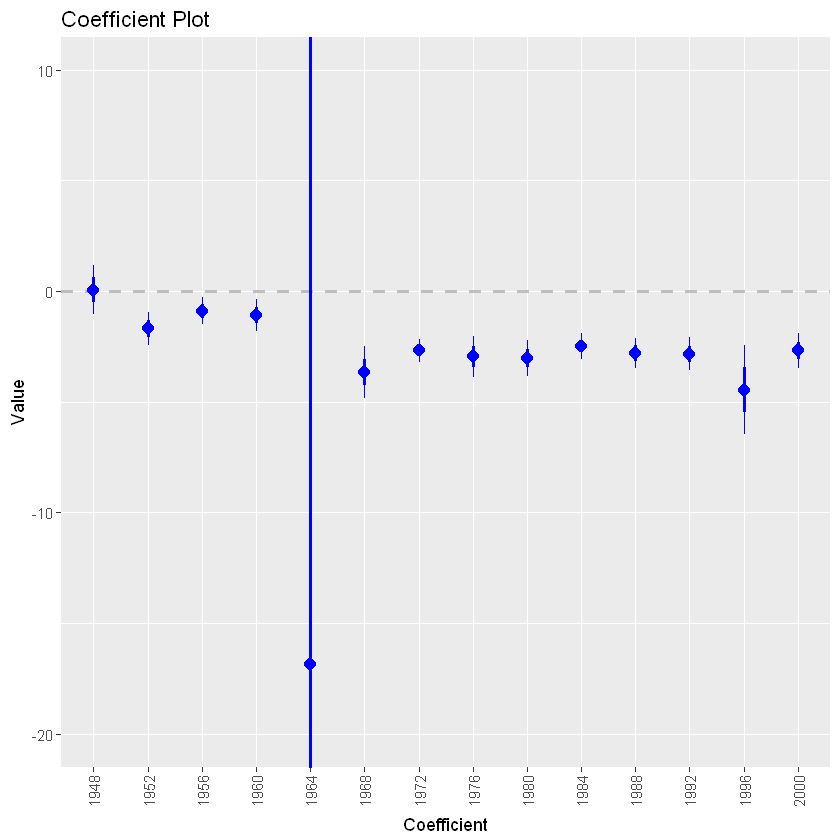

In [10]:
multiplot(results$Model,
         coefficients = "Raceblack", secret.weapon = TRUE) +
coord_flip(xlim=c(-20, 10))

- 1964년 모형은 다른 모형에 비해 추정값에 문제가 있어보인다
- 이러한 문제를 해결하기 위해 모형의 계수에 사전 확률을 부여

In [13]:
install.packages("arm")

also installing the dependencies 'minqa', 'nloptr', 'lme4', 'abind', 'coda'



package 'minqa' successfully unpacked and MD5 sums checked
package 'nloptr' successfully unpacked and MD5 sums checked
package 'lme4' successfully unpacked and MD5 sums checked
package 'abind' successfully unpacked and MD5 sums checked
package 'coda' successfully unpacked and MD5 sums checked
package 'arm' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\student\AppData\Local\Temp\RtmpYnwduq\downloaded_packages


In [14]:
resultsB <- ideo %>%
group_by(Year) %>%
do(Model = arm::bayesglm(Vote ~ Race + Income + Gender + Education,
                        data= .,
                        family = binomial(link = "logit"),
                        prior.scale = 2.5, prior.df = 1))
names(resultsB$Model) <- as.character(resultsB$Year)

Warning message:
"Ignoring unknown aesthetics: xmin, xmax"

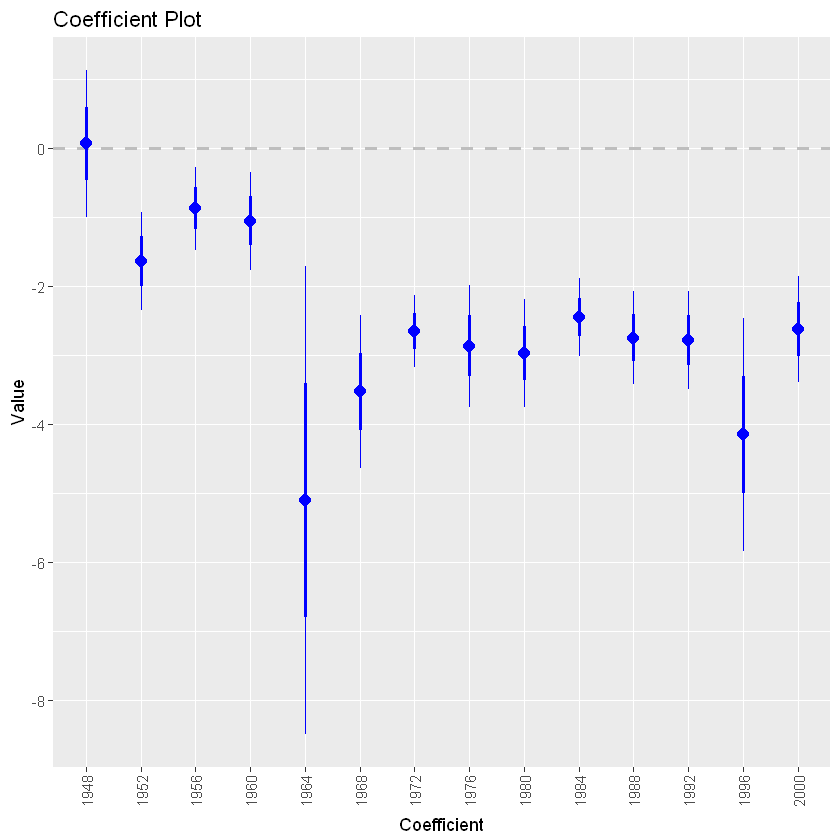

In [16]:
multiplot(resultsB$Model, coefficients = "Raceblack", secret.weapon=T)